Some references:
1. https://www.datasciencecentral.com/profiles/blogs/some-more-social-network-analysis-with-python-centrality-pagerank

2. http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html

3. https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/tree/master/Applied-Social-Network-Analysis-In-Python/week4

Scaled PageRank:
1. https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/blob/204c39794a9966f967d71e5e3fa277eb4bbcae74/Applied-Social-Network-Analysis-In-Python/week3/Assignment%2B3.ipynb

2. https://www.coursera.org/learn/python-social-network-analysis/lecture/xxW11/scaled-page-rank

## Randomly Generated Graphs
We will first generate input graphs using three types of graphs:
- Preferential Attachment
- Small World with low probability of rewiring
- Small World with high probability of rewiring

### Preferential Attachment Model
**1. Degree Distributions**

The degree distribution of a graph is the probability distribution of the degrees over the entire network.

https://github.com/MaxPoon/coursera-Applied-Data-Science-with-Python/blob/master/Applied-Social-Network-Analysis-In-Python/week4/4.1_Preferential-Attachment-Model.pdf

**2. Preferential Attachment Model**
- Start with two nodes connected by an edge
- At each time step, add a new node with an edge connecting it to an existing node
- Choose the node to connect to at random with probability proportional to each node's degree
- The probability of connecting to a node *u* of degree *$k_u$* is $k_u/\sum_j k_j$

做presentation时记得每步说明

As the number of nodes increases, the preferential attachment model produces networks with degree distributions similar to real networks.

**3. Preferential Attachment Model in NetworkX**

barabasi_albert_graph(n, m) returns a network with n nodes. Each new node attaches to m existing nodes according to the Preferential Attachment model.

In [9]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To illustrate this, we create a graph with 1000000 nodes starting from 1 node.

In [12]:
G = nx.barabasi_albert_graph(1000000, 1)
degrees = G.degree()
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

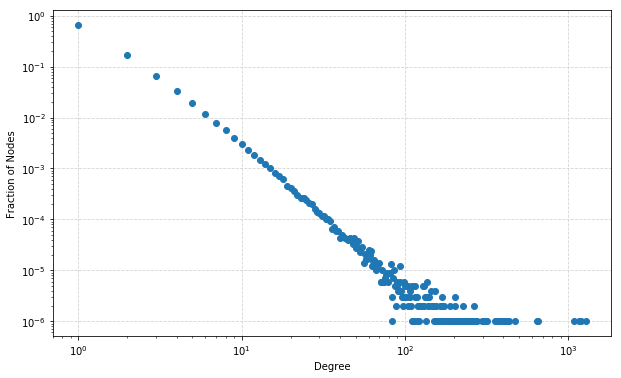

In [13]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(degree_values, histogram, 'o')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.xscale('log')
plt.yscale('log')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

The resulting degree distribution, the probability $P[k]$ of a node chosen uniformly at random having degree $k$ is clearly broadtail with an exponent of approximately 3.

The figure above shows that nodes of degree 100 are approximately 1,000,000 times **less common** than nodes of degree 1.

A consequence of this form of the degree distribution is the existence of “hubs”, or superstars, nodes that account for a disproportionately large number of connections. For example, in a network of 1,000,000 nodes, the Top 1% of nodes by degree account for roughly 21% of all connections and the Top 10 nodes have over 1.5% of the total. This kind of disparity can be seen in many other cases, such as the accumulation of wealth.

### Small World Model
**1. Motivation**

- Real networks exhibit high clustering coefficient and small average shortest paths. 

- The preferential attachment model produces networks with small short paths but very small clustering coefficient.

**2. Small-world model**

- Start with a ring of n nodes, where each node is connected to its k nearest neighbors
- Fix a parameter $p\in [0, 1]$
- Consider each edge $(u, v)$. With probability $p$, select a node $w$ at random and rewire the edge $(u, v)$ so it becomes $(u, w)$.

**3. Small World Model in NetworkX**

watts_strogatz_graph(n, k, p) returns a small world network with n nodes, starting with a ring lattice with each node connected to its k nearest neighbors, and rewiring probability $p$.

We could have a look at the small world network degree distribution.

In [14]:
G = nx.watts_strogatz_graph(1000, 6, 0.04)
degrees = G.degree()
degree_values = sorted(set(degrees.values()))
histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]

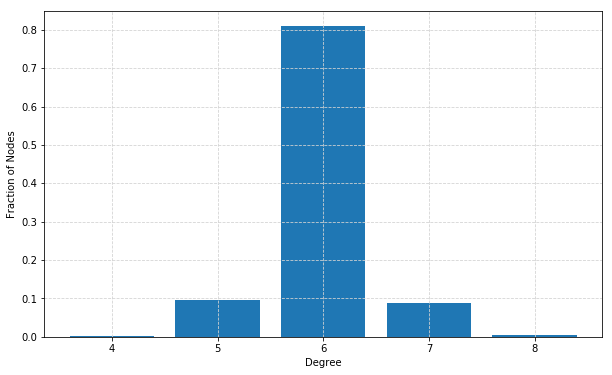

In [15]:
fig, ax = plt.subplots(figsize = (10, 6))
plt.bar(degree_values, histogram)
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

This is a small world network with 1000 nodes, k = 6, and p = 0.04. There is no power law degree distribution.

Meanwhile, since most edges are not rewired, most nodes have degree of 6. Since edges are rewired uniformly at random, no node accumulated very high degree, like in the preferential attachment model.

## GCNN Implementation
https://media.readthedocs.org/pdf/tfgraph/latest/tfgraph.pdf

Implementation of Graph Auto-Encoders in Tensorflow: https://github.com/tkipf/gae

### Input
First we generate a preferential attachment model with 100 nodes starting from 1 node. Since this creates an undirected graph, we converted it to a directed graph. (CORRECTNESS??)

In [62]:
G_temp = nx.barabasi_albert_graph(100, 1)

# initialize an empty directed graph
G = nx.DiGraph()
G.add_edges_from(G_temp.edges())

We could also visualize this directed graph.

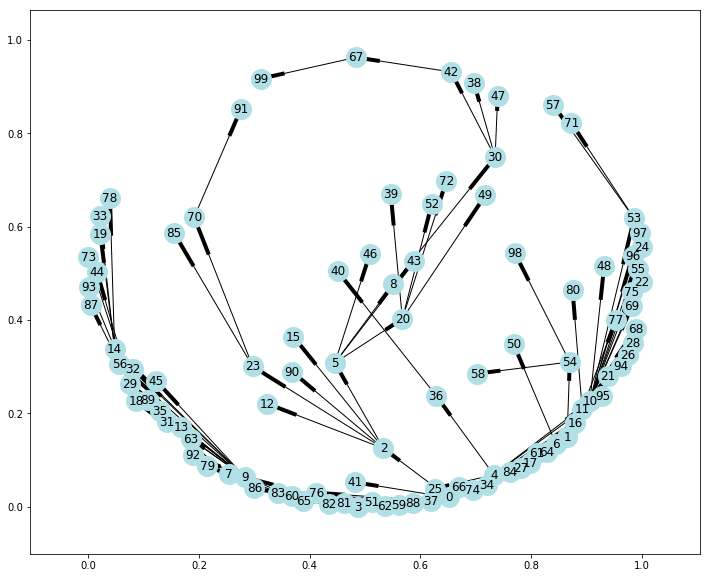

In [63]:
fig, ax = plt.subplots(figsize = (12, 10))
nx.draw_networkx(G, with_labels = True, node_size = 400, node_color = 'powderblue')
plt.show()

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

#threshold for stopping (at what value of sum sq. diffs will we consider this converged?)
threshold = 0.001
#prob that the random surfer teleports 
#see: https://www.math.upenn.edu/~kazdan/312F12/JJ/MarkovChains/markov_google.pdf
surfer_prob = 0.15
#read in and format data
#path = "/path/to/data"
#X = pd.read_csv(path)
X = np.array([[0,0,.3333,0,.333,0,.25],
 			 [0,.5,.3333,0,0,.5,0],
			 [1,0,.3333,.3333,0,0,0],
			 [0,0,0,.3333,.333,0,0],
			 [0,0,0,0,0,0,.25],
			 [0,0,0,0,0,.5,.25],
			 [0,.5,0,.3333,.333,0,.25]])
nrow = X.shape[0]
ncol = X.shape[1]
X2 = np.multiply(np.ones([nrow, ncol]), (surfer_prob/nrow))
X = np.add(np.multiply((1-surfer_prob),X), X2)
val = 1./nrow
vect = np.ones(nrow).reshape(nrow,1)

if nrow != ncol:
	print "Error: must pass the algorithm a square matrix"

A = tf.mul(tf.placeholder(tf.float32, [nrow, ncol]), (1-surfer_prob))
v = tf.placeholder(tf.float32, [ncol, 1])
prev_vector = v
pagerank_vector = tf.matmul(A,v)
change_from_iteration = tf.reduce_sum(tf.square(tf.sub(pagerank_vector, v)), reduction_indices=0) #verify that this is the correct reduction index

init = tf.initialize_all_variables()
with tf.Session() as sess:
	sess.run(init)
	change = float('inf')#sess.run(change_from_iteration, feed_dict={A:X, v:vect})
	while(change > threshold):
		new_vect = sess.run(pagerank_vector, feed_dict={A:X, v:vect}) #update V
		change = sess.run(change_from_iteration, feed_dict={pagerank_vector:new_vect, v:vect})
		vect = new_vect
		#print v.get_shape()
		print vect
		print change
	pr_vector = sess.run(pagerank_vector, feed_dict={A:X, v:vect})
	print pr_vector

### Evaluation
We could evaluate the prediction quality based on the similarities between the predicted ranked lists and the actual top-k ranked lists using *OSim, KSim, NDCG, Spearman correlation*. (https://link.springer.com/content/pdf/10.1007/978-3-642-23960-1_29.pdf)

A framework for Web Page Rank Prediction

## Comparison with exact algorithm
(nx.pagerank in networkX?)